### Setup

In [1]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath(".."))
from src.data_processing import load_processed_data, process_csv_to_numpy, save_processed_data
from src.visualization import (
    plot_rating_distribution, 
    plot_long_tail, 
    plot_popularity_vs_quantity,
    plot_temporal_trends,
    plot_user_consistency
)

### Process raw data

In [2]:
RAW_DATA_PATH = "../data/raw/ratings_Beauty.csv"
PROCESSED_FOLDER = "../data/processed"

data, user_map, product_map, corrupted_rows = process_csv_to_numpy(RAW_DATA_PATH)
if data is None:
    print("Data processing failed")
else:
    save_processed_data(data, user_map, product_map, PROCESSED_FOLDER)

Starting to process CSV file: ../data/raw/ratings_Beauty.csv
Raw Data shape: (2023070, 4)
Saved processed data matrix to ../data/processed\data_processed.npy
Saved user and product maps to ../data/processed


### Check data

In [3]:
print(f"Data Loaded: Shape: {data.shape}")

Data Loaded: Shape: (2023070, 4)


In [4]:
print(f"Users: {len(user_map)}")
print(f"Products: {len(product_map)}")

Users: 1210271
Products: 249274


### Check corrupted_rows

In [5]:
print(f"Corrupted size: {len(corrupted_rows)}")

Corrupted size: 0


In [6]:
print(f"Corrupted: {corrupted_rows}")

Corrupted: []


### Compute Data Sparsity
Độ thưa (Sparsity) là thước đo tỷ lệ phần trăm các ô trống (missing values) trong ma trận tương tác Người dùng - Sản phẩm (User-Product Matrix).
Công thức: 
$$
Sparsity = 1 - \frac{\text{Số lượng đánh giá thực tế}}{\text{Tổng số User} \times \text{Tổng số Product}}
$$
Ví dụ: Nếu Sparsity = 0.9999, điều đó có nghĩa là 99.99% các ô trong ma trận là rỗng, chỉ có 0.01% là có dữ liệu.\
Với bộ dữ liệu **Amazon - Ratings (Beauty Products)**, ta tính toán được độ thưa lên tới `0.99999329` chứng tỏ trong hàng triệu sản phẩm được bán thì chỉ có một phần nhỏ đánh giá, ma trận dữ liệu của chúng ta hầu như chỉ là các ô trống. Điều này gây khó khăn khi xây dựng mô hình vì với dữ liệu quá ít, mô hình không đủ thông tin để học được sở thích của người dùng hay việc tìm ra những người có chung sở thích là rất khó khăn vì xác suất để hai người mua cùng một sản phẩm là cực kỳ thấp.

In [7]:
n_users = len(user_map)
n_products = len(product_map)
n_ratings = data.shape[0]

total_possible_ratings = n_users * n_products
sparsity = 1 - (n_ratings / total_possible_ratings)

print(f"Matrix Sparsity: {sparsity:.8f}")

Matrix Sparsity: 0.99999329


### Khám phá dữ liệu

#### Kiểm tra tổng quan về dữ liệu

In [8]:
print(f"Data sample:\n{data[:5]}")

Data sample:
[[0.0000000e+00 0.0000000e+00 5.0000000e+00 1.3696992e+09]
 [1.0000000e+00 1.0000000e+00 3.0000000e+00 1.3554432e+09]
 [2.0000000e+00 1.0000000e+00 5.0000000e+00 1.4046912e+09]
 [3.0000000e+00 2.0000000e+00 4.0000000e+00 1.3825728e+09]
 [4.0000000e+00 3.0000000e+00 1.0000000e+00 1.2742272e+09]]


In [9]:
print(f"Data size: {data.size}")

Data size: 8092280


In [10]:
print(f"Data shape: {data.shape}")

Data shape: (2023070, 4)


In [11]:
print(f"Data type: {data.dtype}")

Data type: float32


#### Khám phá cột **rating** (index = 2)

In [12]:
ratings = data[:, 2]
print(f"Ratings sample:\n{ratings[:5]}")

Ratings sample:
[5. 3. 5. 4. 1.]


In [13]:
print(f"len(ratings): {len(ratings)}")

len(ratings): 2023070


In [14]:
print(f"Check missing values in ratings: {np.isnan(ratings).any()}")

Check missing values in ratings: False


#### Thống kê mô tả cho cột rating

In [15]:
min_rating, max_rating = np.min(ratings), np.max(ratings)
mean_rating, median_rating = np.mean(ratings), np.median(ratings)
std_rating = np.std(ratings)
percentiles = np.percentile(ratings, [25, 50, 75])
print(f"Rating Statistics:")
print(f"Min: {min_rating}")
print(f"Max: {max_rating}")
print(f"Mean: {mean_rating:.2f}")
print(f"Median: {median_rating}")
print(f"Std Dev: {std_rating:.2f}")
print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile: {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")

Rating Statistics:
Min: 1.0
Max: 5.0
Mean: 4.15
Median: 5.0
Std Dev: 1.31
25th Percentile: 4.0
50th Percentile: 5.0
75th Percentile: 5.0


#### Ý nghĩa
1. Min
    - Giá trị `min = 1`, nghĩa là dataset có chứa phản hồi tiêu cực, chứng tỏ dải dữ liệu không bị thiếu.
2. Max
    - Giá trị `max = 5`, nghĩa là dataset có chứa phản hồi tích cực, chứng tỏ dải dữ liệu không bị thiếu.
3. Mean
    - Giá trị `mean = 4.15`. Điều này tương đối bất thường trong thực tế, chứng tỏ hầu hết các sản phẩm đều được đánh giá là **positive**.
    - Recommender Systems cần lưu ý vì ít đánh giá **negative**, mô hình dễ bị bias.
4. Median
    - Giá trị `median = 5` chứng tỏ phân phối bị lệnh phải, chủ yếu là rating cao. Điều này cho thấy rằng đa số người dùng hài lòng hoặc họ không đánh giá khi không hài lòng.
    - Việc median cao hơn mean $\to$ chứng tỏ phân phối nghiêng về đánh giá cao.
5. Std dev
    - Giá trị `std = 1.31`, giá trị này không quá cao chứng tỏ dữ liệu không quá đa dạng, phần lớn người dùng đánh giá 4-5 sao.
6. 25th percentile
    - Giá trị `25th Percentile = 4.0`, có nghĩa là có 25% số rating <= 4. Tức là rating 1-3 rất ít.
7. 50th percentile
    - Tương tự như `median`. Khi median = max, phân phối càng lệch về phía cao (right-skew).
8. 75th percentile
   - Giá trị `75th Percentile = 5.0`, có nghĩa là có 75% người dùng đều cho rating 5 sao.

#### Một số lưu ý được rút ra từ kết quả thống kê trên
- Dữ liệu thiếu tính phân biệt: Nếu hầu hết đều chấm 4–5 thì mô hình khó học sự khác biệt sở thích thực sự.
- Nên kiểm tra Long Tail: Xem sản phẩm nào được rating rất ít $\to$ Cold start.
- Cần đảm bảo K-core filtering: Để loại người dùng / sản phẩm quá ít rating.

### Một số câu hỏi có ý nghĩa

#### **Câu hỏi 1: Khách hàng có xu hướng "dễ tính" hay "khắt khe" khi đánh giá?**
**Mục đích:** Hiểu về **Rating Distribution (Phân phối điểm số)**. Nếu dữ liệu bị lệch, ví dụ toàn 5 sao, mô hình sẽ rất khó học được cái gì là "ghét".


d:\Coding\Programming_DS\HW02\RecommendationSystem\src\visualization.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=unique_ratings, y=counts, palette=colors)


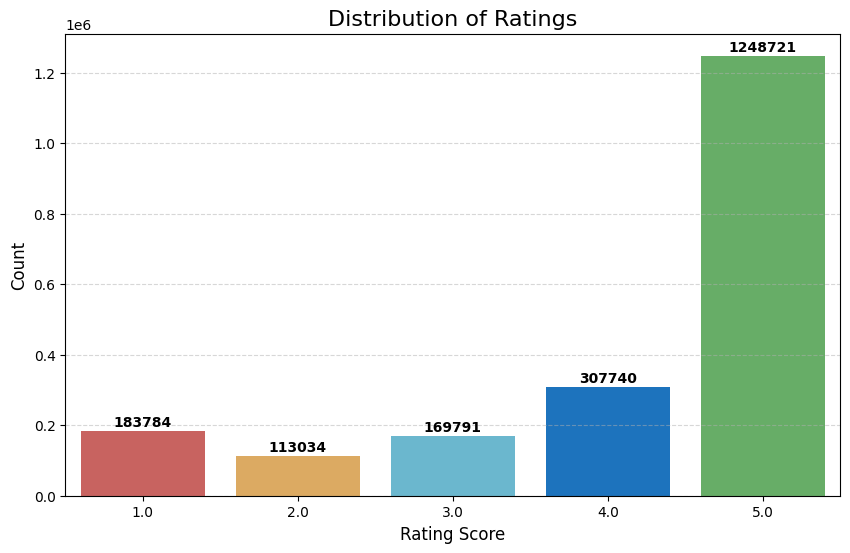

In [16]:
plot_rating_distribution(data)

Biểu đồ này trực quan hóa tần suất xuất hiện của các mức điểm từ 1.0 đến 5.0. Mục tiêu là để kiểm tra mức độ cân bằng của dữ liệu (Data Balance).
- **Ý nghĩa:** Trong thương mại điện tử, người dùng có xu hướng chỉ đánh giá khi họ thực sự hài lòng (Positive bias). Chắc hẳn đây là tâm lý chung của nhiều người, khi sản phẩm khiến họ cảm thấy hài lòng, tâm trạng vui vẻ sẽ thúc đẩy người dùng đánh giá tốt cho sản phẩm. Ngoài ra, một chiến lược được áp dụng rộng rãi ngày nay là khi gửi sản phẩm đến tay người dùng, doanh nghiệp sẽ gửi một tờ phiếu nhỏ kèm theo với lời nhắn thường có nội dung "Nếu cảm thấy không hài lòng về sản, đừng vội đánh giá 1 sao, hãy liên hệ lại với cửa hàng để được hỗ trợ", chính vì điều này thường khiến cho hầu hết các sản phẩm trên các sàn thương mại điện tử đều được đánh giá cao. Với sự mất cân bằng về dữ liệu như vậy, mô hình học máy sẽ gặp khó khăn trong việc phân biệt giữa sản phẩm "thực sự xuất sắc" và sản phẩm "bình thường nhưng được chấm nương tay".
- **Kết luận:** Dữ liệu bị mất cân bằng nghiêm trọng (Skewed Data). Khách hàng trên Amazon có xu hướng chỉ đánh giá khi họ rất hài lòng.
- **Hệ quả:** Mô hình gợi ý sẽ có xu hướng dự đoán điểm cao (bias). Một sản phẩm được dự đoán 4.0 có thể coi là "tệ" so với mặt bằng chung toàn 5.0.

#### **Câu hỏi 2:** Dữ liệu có tuân theo nguyên lý Pareto (80/20) không?
**Mục đích:** Kiểm tra **Long-tail Phenomenon**. Có phải một nhóm nhỏ khách hàng\sản phẩm tạo ra phần lớn ảnh hưởng? Hay một nhóm nhỏ sản phẩm chiếm hết doanh số?\
Trước tiên, ta cần tìm hiểu về **Phân phối Long-tail**.

##### Phân phối đuôi dài (Long tail)
Trong hầu hết các hệ thống E-commerce, dữ liệu tuân theo **nguyên lý Pareto** (Quy tắc 80/20) hoặc định luật lũy thừa (Power Law). Biểu đồ sẽ có dạng chữ "L" đặc trưng với hai phần rõ rệt:
<img src="https://media.nngroup.com/media/editor/2021/11/29/the-long-tail.jpg" alt="Rating Distribution" width="400">
- **Phần đầu (The head):** Một số lượng rất nhỏ các sản phẩm "Hot" (Best-sellers) hoặc người dùng "Power Users" chiếm phần lớn tổng số lượng tương tác. Đây là vùng dữ liệu dày đặc, nơi các thuật toán lọc cộng tác (Collaborative Filtering) hoạt động rất tốt.
- **Phần đuôi (The tail):** Phần còn lại trải dài vô tận về phía bên phải. Đây là hàng trăm nghìn sản phẩm chỉ được mua 1-2 lần, hoặc những người dùng chỉ ghé thăm một lần rồi đi. Mặc dù mỗi cá thể ở phần đuôi có lượng tương tác thấp, nhưng tổng hợp lại, chúng chiếm một khối lượng sản phẩm khổng lồ (Niche market).

**Trả lời:** Đầu tiên hãy quan sát đồ thị Long-tail của User và Products

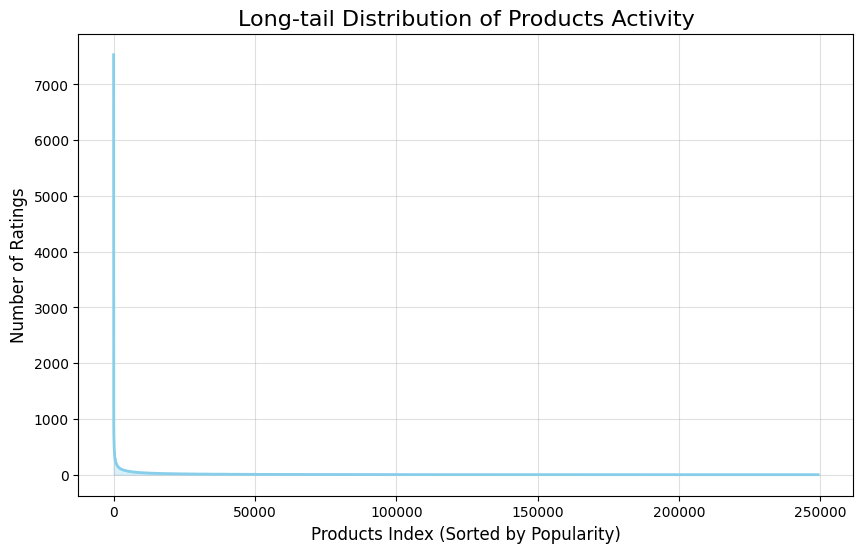

In [17]:
plot_long_tail(data, column_index=1, entity_name="Products")

##### Phân phối Long-tail của **Products**
- Ý nghĩa các trục:
  - Trục x: Products index (sắp xếp theo độ phổ biển giảm dần)
  - Trục y: Số lượng rating
- Biểu đồ thể hiện phân phối Long-tail:
  - **Phần đầu:** Một số rất ít sản phẩm (bên trái biểu đồ) nhận rất nhiều đánh giá (~7000 ratings cho sản phẩm phổ biến nhất). Đây là các sản phẩm cực kỳ hot, được người dùng review nhiều.
  - **Phần đuôi:** Phần lớn sản phẩm (bên phải biểu đồ) có rất ít rating, nhiều sản phẩm chỉ có vài hoặc thậm chí 1 rating. Đuôi dài $\to$ phân phối long-tail, phổ biến trong các dataset e-commerce như Amazon.

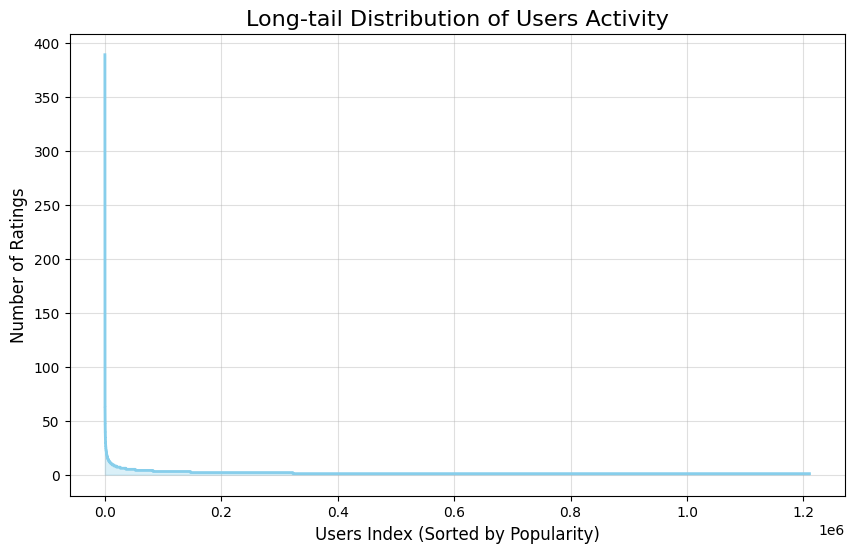

In [18]:
plot_long_tail(data, column_index=0, entity_name="Users")

##### Phân phối Long-tail của **Users**
- Ý nghĩa các trục:
  - Trục x: Users index (sắp xếp theo độ phổ biến giảm dần)
  - Trục y: Số lượng rating
- Biểu đồ thể hiện phân phối Long-tail: 
  - **Phần đầu:** Ở phía bên trái biểu đồ, có một số rất ít người dùng nhận được số lượng đánh giá cực lớn (gần 400 rating). Đây là nhóm người dùng phổ biến hoặc rất hoạt động, chiếm tỷ lệ nhỏ nhưng tạo ra phần lớn tương tác.
  - **Phần đuôi:** Phần đuôi trải dài về phía phải, hầu hết các người dùng chỉ nhận được rất ít đánh giá (gần bằng 0–5 rating). Điều này cho thấy đa số người dùng ít hoạt động, hoặc sản phẩm mà họ đánh giá không phổ biến.

**Quan sát:** Đường biểu đồ sẽ dốc đứng ở đầu và nằm bẹp dí ở đuôi (hình chữ L).\
**Kết luận:** Rất có thể Top 1% người dùng/sản phẩm đóng góp tới **20-30%** dữ liệu.\
**Hướng đi:** Đây là lý do bắt buộc phải lọc **K-Core**. Những người dùng/sản phẩm ở phần "đuôi dài" là nhiễu, không mang lại giá trị cho việc học thói quen (pattern).

#### **Câu 3:** Sản phẩm bán chạy nhất (Popular) có phải là sản phẩm tốt nhất (Best Quality) không?
**Mục đích:** Tìm mối tương quan giữa Số lượng bán và Điểm đánh giá trung bình. Liệu cứ nhiều người mua thì điểm sẽ cao?\
Trước tiên hãy quan sát sự tương quan giữa độ phổ biến và chất lượng từ đồ thị bên dưới

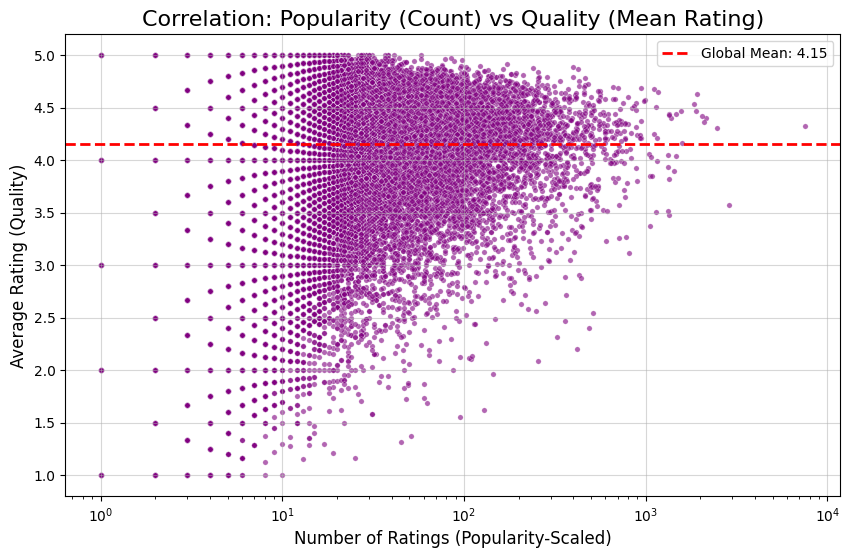

In [19]:
plot_popularity_vs_quantity(data)

**Trả lời:** Sản phẩm bán chạy nhất không hẳn là sản phẩm có chất lượng tốt nhất. Sản phẩm bán chạy thường có chất lượng "khá ổn" và "ổn định" nhưng hiến khi đạt được điểm tuyệt đối (5.0) như các sản phẩm ít người mua.

**Phân tích chi tiết dựa trên đồ thị:**\
Khi nhìn vào biểu đồ Scatter plot này, bạn sẽ thấy một hình dạng đặc trưng giống cái phễu hoặc hình tam giác nằm ngang hướng mũi nhọn về bên phải.

**1. Khu vực bên trái (Popularity thấp - Ít người mua)**
  - **Quan sát:** Các điểm chấm phân tán cực mạnh dọc theo trục tung, trải dài từ 1.0 đến 5.0.
  - **Lý giải:** Đây là những sản phẩm chỉ có 1-2 đánh giá. Nếu một người mua và đánh giá 5.0 $\to$ trung bình là 5.0 nhưng độ tin cậy lại cực thấp. Nếu người mua và đánh giá 1.0 $\to$ trung bình là 1.0 nhưng chưa chắc đây là sản phẩm không tốt.
  - **Kết luận:** Ở vùng này, điểm trung bình bị **Phương sai** cao chi phối. Một sản phẩm 5 sao ở đây chưa chắc đã tốt, có thể do ăn may hoặc quảng cáo.

**2. Khu vực bên phải (Popularity cao - Sản phẩm bán chạy)**
  - **Quan sát:** Các điểm chấm bắt đầu tụ lại và hội tụ về một khoảng hẹp, thường nằm quanh mức 4.0 đến 4.5 (gần đường kẻ đỏ Global Mean). Ta sẽ không thấy chấm nào đạt 5.0 tuyệt đối ở khu vực này.
  - **Lý giải (Hiện tượng "Hồi quy về giá trị trung bình" - Regression to the mean):** Khi một sản phẩm có 10000 người mua, xác suất tất cả 10000 người đều đánh giá 5.0 cho sản phẩm đó gần như bằng 0. Sẽ luôn có những trường hợp đánh giá thấp hơn 5.0 vì một số lý do như hàng bị hỏng, vận chuyển trễ,... khiến điểm đánh giá trung bình bị kéo xuống.
  - **Kết luận:** Sản phẩm bán chạy nhất là sản phẩm **Đáng tin cậy** và **Phổ thông**, nhưng về mặt con số toán học, nó không phải là sản phẩm có điểm cao nhất. 
  
**3. Mối tương quan:**
  - Nhìn tổng thể, không có đường thẳng dốc lên rõ rệt nào nối từ trái sang phải. Điều này chứng tỏ: **Độ phổ biến** không tỉ lệ thuận tuyến tính với **Chất lượng**.
  - Tuy nhiên, có một sự chọn lọc tự nhiên: Những sản phẩm quá tệ (1-2 sao) thường sẽ không tồn tại được lâu để tích lũy đủ lượng rating cao (chúng sẽ bị đào thải sớm). Do đó, các sản phẩm ở vùng bên phải (bán chạy) hầu hết đều nằm trên mức trung bình (trên đường kẻ đỏ).

#### **Câu 4:** Xu hướng hoạt động theo thời gian?
Trước tiên hãy nhìn vào đồ thị bên dưới

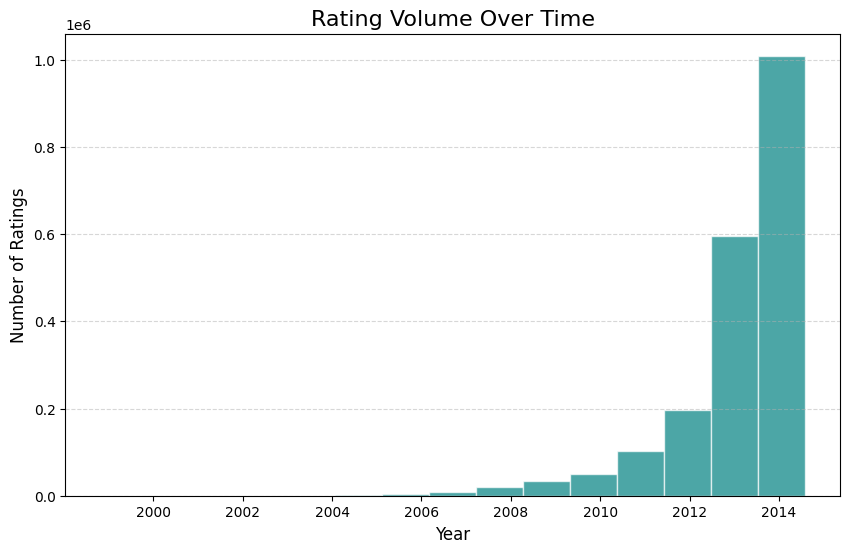

In [20]:
plot_temporal_trends(data)

**Trả lời:**
Dựa vào biểu đồ **Rating Volume Over Time**, ta thấy một sự chênh lệch cực kỳ lớn về lượng dữ liệu giữa quá khứ và thời điểm 2014. Cụ thể:

**1. Sự thống trị tuyệt đối của năm 2014**
  - **Quan sát:** Cột năm 2014 cao vọt lên, chạm ngưỡng hơn 1000000 lượt đánh giá.
  - **So sánh:**
    - Năm 2013: Khoảng 600.000 đánh giá.
    - Năm 2012: Khoảng 200.000 đánh giá.
    - Năm 2014 gần như gấp đôi năm 2013 và gấp 5 lần năm 2012.
  - **Ý nghĩa:** Năm 2014 không chỉ là năm cao nhất, mà lượng dữ liệu của riêng năm này có thể bằng tổng tất cả các năm trong lịch sử cộng lại. Đây là một sự "áp đảo" dữ liệu cực lớn.

**2. Giai đoạn "Vô hình" (Trước 2011)**
  - Từ năm 2011 trở về trước (2000-2010), các thanh biểu đồ thấp đến mức gần như không nhìn thấy trên thang đo triệu đơn vị này.
  - Kết luận: Đối với quy mô hiện tại của hệ thống (năm 2014), dữ liệu quá khứ coi như không tồn tại. Hành vi mua sắm của khách hàng trước 2011 không có bất kỳ trọng lượng số học nào trong bài toán này.
  
**3. Nhận định về hành vi người dùng** 
  - **Làn sóng người dùng mới:** Sự tăng vọt từ 600k lên 1 triệu chỉ trong 1 năm cho thấy có một lượng khổng lồ người dùng mới gia nhập nền tảng vào năm 2014.
  - **Hệ quả Cold-Start:** Vì 2014 chiếm tỷ trọng quá lớn và chứa nhiều người dùng mới, khả năng cao là ma trận dữ liệu của chúng ta chứa rất nhiều người dùng chỉ mới mua 1-2 món hàng. Điều này giải thích tại sao biểu đồ Long-tail lại dốc như vậy.

#### **Câu 5:** Hành vi đánh giá của người dùng có đủ phức tạp để cần đến mô hình học máy?
**Đặt tình huống: Liệu bài toán này có thật sự khó?**
  - Nếu mọi người đều có xu hướng đánh giá tốt khi mua bất kỳ món hàng nào thì ta chỉ cần đoán số 5.0.
  - Ngược lại, ta cần một thuật toán Machine Learning để học ra quy luật đánh giá sản phẩm của khách hàng.
  
Ta cùng xem qua biểu đồ phía bên dưới

Global Mean Rating: 4.1490
Baseline RMSE (Predict Global Mean): 1.3115


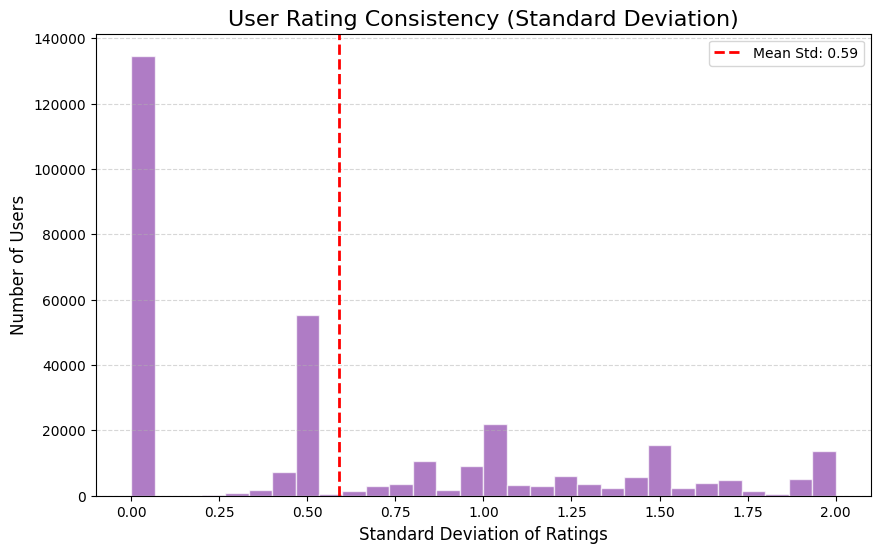

In [21]:
plot_user_consistency(data)

**Trả lời:**\
**1. Phân tích Baseline RMSE (Sai số của việc đoán mò)**
  - **Con số thực tế:** `Baseline RMSE = 1.3115`.
  - **Ý nghĩa:** Nếu hệ thống chỉ đoán mò tất cả người dùng đều thích sản phẩm ở mức trung bình (khoảng 4.15 sao), thì trung bình mỗi dự đoán sẽ bị sai lệch khoảng 1.3 sao.
  - **Tại sao con số này tệ?**
    - Trên thang điểm 5, sai số 1.3 tương đương với **26%** toàn bộ thang đo.
    - Ví dụ thực tế: Một khách hàng khó tính mua sản phẩm và chấm 2 sao (Tệ). Hệ thống dự đoán 4.15 sao (Tốt). Sai lệch là $|2 - 4.15| = 2.15$.
    - **Hậu quả:** Khách hàng sẽ cảm thấy bị lừa dối vì hệ thống gợi ý sai lệch quá nhiều so với nhu cầu của họ. Phương pháp đoán trung bình thất bại.

**2. Phân tích Biểu đồ Histogram**\
Biểu đồ cho thấy cộng đồng người dùng Amazon chia làm 2 phe rõ rệt/
  - **Phe nhất quán:**
    - Có hơn 130000 người dùng có độ lệch chuẩn bằng 0.
    - **Hành vi:** Họ cực kỳ kiên định, lúc nào cũng chấm 5 sao hoặc lúc nào cũng chấm 1 sao.
    - **Thách thức ẩn:** Dù họ nhất quán, nhưng nếu ta dùng `Global Mean = 4.15` để đoán cho một khách hàng luôn đánh giá 1 sao, ta sẽ sai rất nặng. Ta cần mô hình học được tham số **User Bias ($b_u$)** để biết ai là người luôn đánh giá thấp, ai luôn đánh giá cao.
  - **Phe thất thường:**
    - Nhìn vào phần đuôi bên phải, có hàng chục nghìn người dùng có độ lệch chuẩn rất cao (> 1.0).
    - **Hành vi:** Đây là nhóm khách hàng phức tạp, sự đánh giá đối với một sản phẩm của họ không có tính nhất quán.
    - **Thách thức:** Với nhóm này, đoán trung bình hay đoán theo bias đều không đúng. Ta bắt buộc phải dùng **Matrix Factorization** để tìm ra các Đặc trưng ẩn nhằm giải thích tại sao họ thích món này nhưng ghét món kia.

**3. Kết luận chiến lược**
  - Baseline RMSE cao tới **1.3115** là bằng chứng cho thấy bài toán này không hề đơn giản.
  - Sự tồn tại song song của nhóm người dùng siêu nhất quán và nhóm siêu thất thường đòi hỏi một mô hình linh hoạt. Mô hình **Matrix Factorization** cần phải đạt được mục tiêu: **Giảm RMSE từ 1.31 xuống dưới 1.0**. Phần chênh lệch đó chính là giá trị mà AI mang lại so với các phương pháp thống kê thông thường."